# Fourier Transformation

### Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
import sys
sys.version

'3.7.1 (default, Dec 14 2018, 19:28:38) \n[GCC 7.3.0]'

### main variables

In [3]:
image_path = "../images/aina_medium.jpg"

### functions

In [4]:
#Source: https://stackoverflow.com/a/42314798

def plotimage(img, title=None, figsize=None, invert=False):
    if invert:
        img = np.max(img) - img.copy()
        
    h = img.shape[0]
    w = img.shape[1]
    dpi = 80
    if figsize is None:
        figsize = w / float(dpi), h / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])    
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

### code

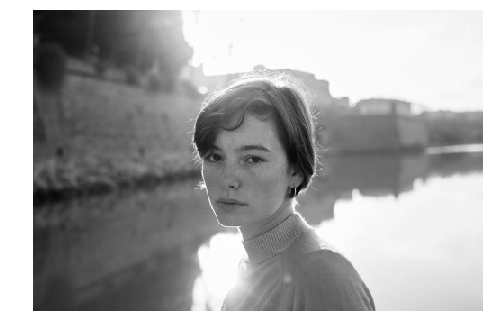

In [5]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# img = np.zeros((500,500), dtype='uint8')
# r,c = img.shape[0]//2,img.shape[1]//2
# n=20
# cv2.circle(img, (c,r), n, 1, -1)

plotimage(img)

### fourier

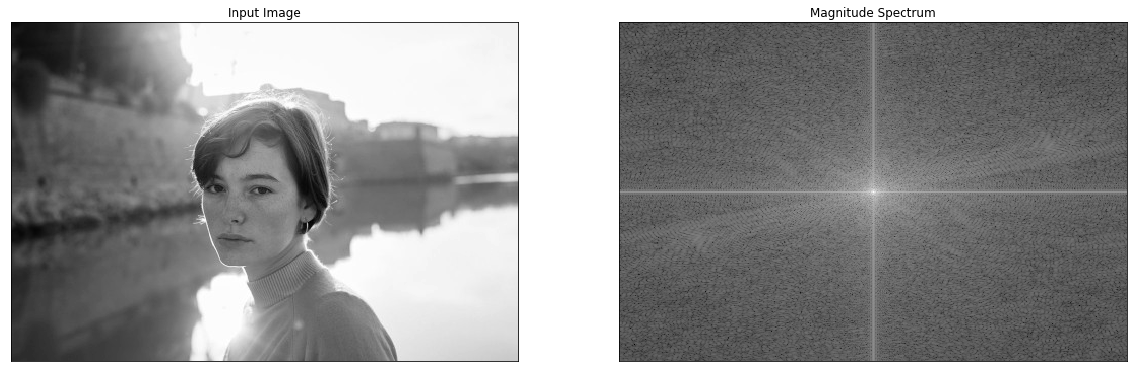

In [6]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

#for plotting
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


### Filtering

In [7]:
def get_filter(r,c, w1,w2=None, mode='lpf'):
    if mode=='lpf' or mode == 'hpf':
        pf = np.zeros((r,c), dtype='uint8')
        crow,ccol = r//2 , c//2    
        cv2.circle(pf,(ccol,crow),w1,1, -1)
        if mode == 'lpf':
            return pf
        if mode == 'hpf':
            return 1-pf

        return None
    
    if mode == 'bpf' or mode == 'bsf':
        hpf = get_filter(r=r,c=c,w1=w1, mode='hpf')
        lpf = get_filter(r=r,c=c,w1=w2, mode='lpf')
        bpf = hpf * lpf
        if mode == 'bpf':
            return bpf
        if mode == 'bsf':
            return 1-bpf
        return None
    
    if mode in ('blpf','bhpf','glpf','ghpf'):
        w,h=c,r        
        x,y = np.meshgrid(list(range(w)),list(range(h)))
        center = (w//2,h//2)
        z = np.sqrt(np.square(x-center[0]) + np.square(y-center[1]))
        if mode in ('blpf','bhpf'):
            b = 1/(1+np.square(z/w1))
            if mode == 'blpf':            
                return b
            if mode == 'bhpf':
                return 1-b
    
        if mode in ('glpf','ghpf'):
            b = np.exp(-np.square(z)/(2*np.square(w1)))
            if mode == 'glpf':            
                return b
            if mode == 'ghpf':
                return 1-b
    
    return None

In [8]:
def apply_filter(f_shifted, w1=50,w2=None, mode='lpf', return_filter=False):
    rows, cols = f_shifted.shape
    
    f_shifted = f_shifted.copy();
    
    w1 = min(min(f.shape[0], f.shape[1]), w1)
    if w2 is not None:
        w2 = min(min(f.shape[0], f.shape[1]), w2)
        
    if mode == 'bpf' or mode == 'bsf':
        if w2 is None:
            raise Exception("Error! 'w2' should be specified for this kind of filter!")

    pf = get_filter(r=f.shape[0], c=f.shape[1],w1=w1,w2=None, mode=mode)
    if return_filter:
        return f_shifted*pf, pf
    return f_shifted*pf;

In [9]:
def HPF(f_shifted, w0=50):
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='hpf')

In [10]:
def LPF(f_shifted, w0=50):
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='lpf')    

In [11]:
def BPF(f_shifted, w1=50,w2=100):
    return apply_filter(f_shifted=f_shifted, w1=w1,w2=w2, mode='bpf')        

In [12]:
def BSF(f_shifted, w1=50,w2=100):
    return apply_filter(f_shifted=f_shifted, w1=w1,w2=w2, mode='bsf')        

In [13]:
def BLPF(f_shifted, w0=50):
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='blpf')

In [14]:
def BHPF(f_shifted, w0=50):
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='bhpf')

In [15]:
def GLPF(f_shifted, w0=50):
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='glpf')

In [16]:
def GHPF(f_shifted, w0=50):
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='ghpf')

### Apply Filter & Inverse Fourier

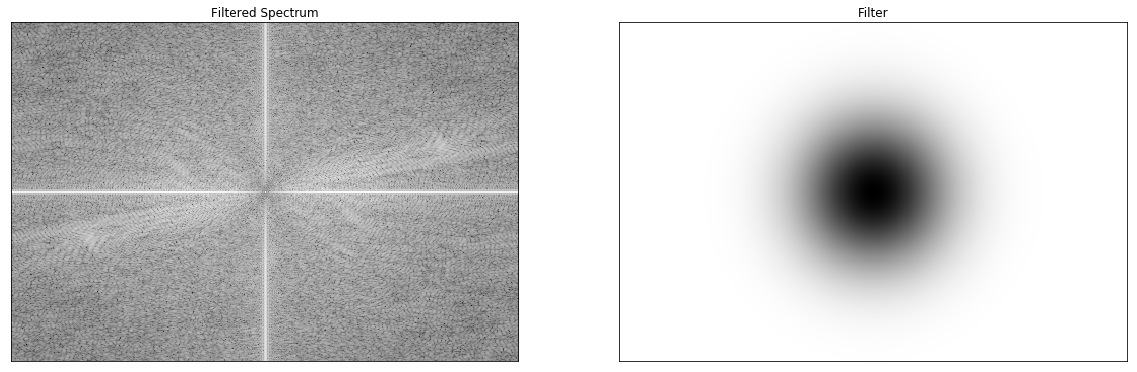

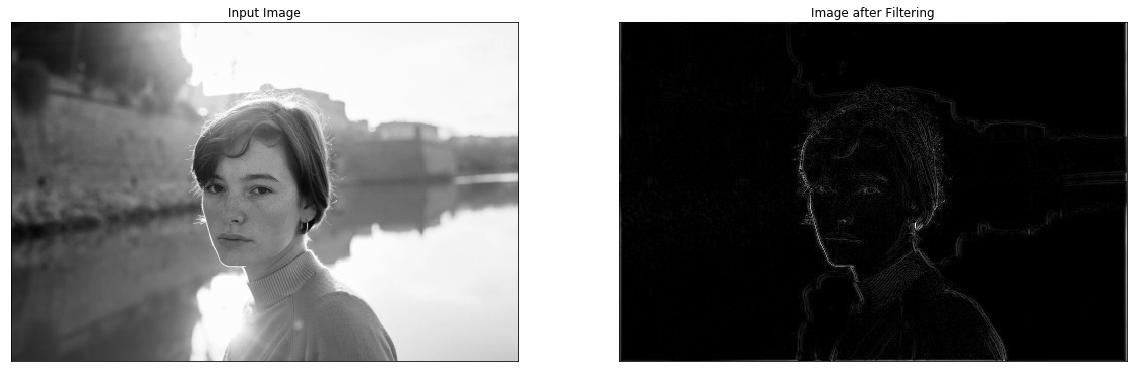

In [20]:
filter_name = 'ghpf'
w1 = 50
w2 = None
fshift_filtered, filter = apply_filter(f_shifted=fshift, w1=w1,w2=w2, mode=filter_name, return_filter=True)
# fshift_filtered = fshift
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(figsize=(20,20))
magnitude_spectrum = 20*np.log(np.abs(fshift_filtered))
plt.subplot(121),plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(filter, cmap='gray')
plt.title('Filter'), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after Filtering'), plt.xticks([]), plt.yticks([])


plt.show()